In [8]:
import bladerf
from bladerf import _bladerf
import numpy as np
import matplotlib.pyplot as plt
import struct
import threading
import matplotlib.animation as animation
from timeit import default_timer as timer
import scipy.signal as signal
from scipy.signal import butter, lfilter
from multiprocessing.pool import ThreadPool
from utils import Utils
from numpy.lib.stride_tricks import sliding_window_view



In [9]:

class TX_RX():
    def __init__(self):

        self.utils = Utils()

        self.CENTER_FREQ = int(2.4e9)
        #in Hz, need this due to DC offset generated at the center frequency
        self.FREQ_OFFSET = int(5e6)
        #in Hz
        self.OFFSET_CENTER_FREQ = self.CENTER_FREQ - self.FREQ_OFFSET
        #in Msps
        self.SAMPLE_RATE = int(15e6)
        #in dB
        self.GAIN_RX = 60

        self.GAIN_TX = 60

        #in Hz
        self.BANDWIDTH = self.SAMPLE_RATE/2

        self.num_samples = 4096

        self.sdr = _bladerf.BladeRF(device_identifier="*:serial=a66")
        # self.sdr_tx = _bladerf.BladeRF(device_identifier="*:serial=104")


        #Set up RX Channel information
        self.rx_ch = self.sdr.Channel(_bladerf.CHANNEL_RX(0))
        self.rx_ch.gain_mode = _bladerf.GainMode.Manual
        self.rx_ch.gain = self.GAIN_RX
        self.rx_ch.frequency = self.OFFSET_CENTER_FREQ
        self.rx_ch.sample_rate = self.SAMPLE_RATE
        self.rx_ch.bandwidth = self.BANDWIDTH


        self.bytes_per_sample = 4
        self.buf = bytearray(self.num_samples*self.bytes_per_sample)

        self.sdr.sync_config(layout = _bladerf.ChannelLayout.RX_X1, # or RX_X2
                    fmt = _bladerf.Format.SC16_Q11, # int16s
                    num_buffers    = 16,
                    buffer_size    = 8192,
                    num_transfers  = 8,
                    stream_timeout = 3500)
        

        self.rx_ch.enable = True

    def receive(self):

        self.sdr.sync_rx(self.buf, self.num_samples) # Read into buffer
        self.data = np.frombuffer(self.buf, dtype=np.int16)
        self.data = self.data[0::2] + 1j * self.data[1::2] # Convert to complex type
        self.data /= 2048.0 # Scale to -1 to 1 (its using 12 bit ADC)


    def close_dev(self):
        self.sdr.close()


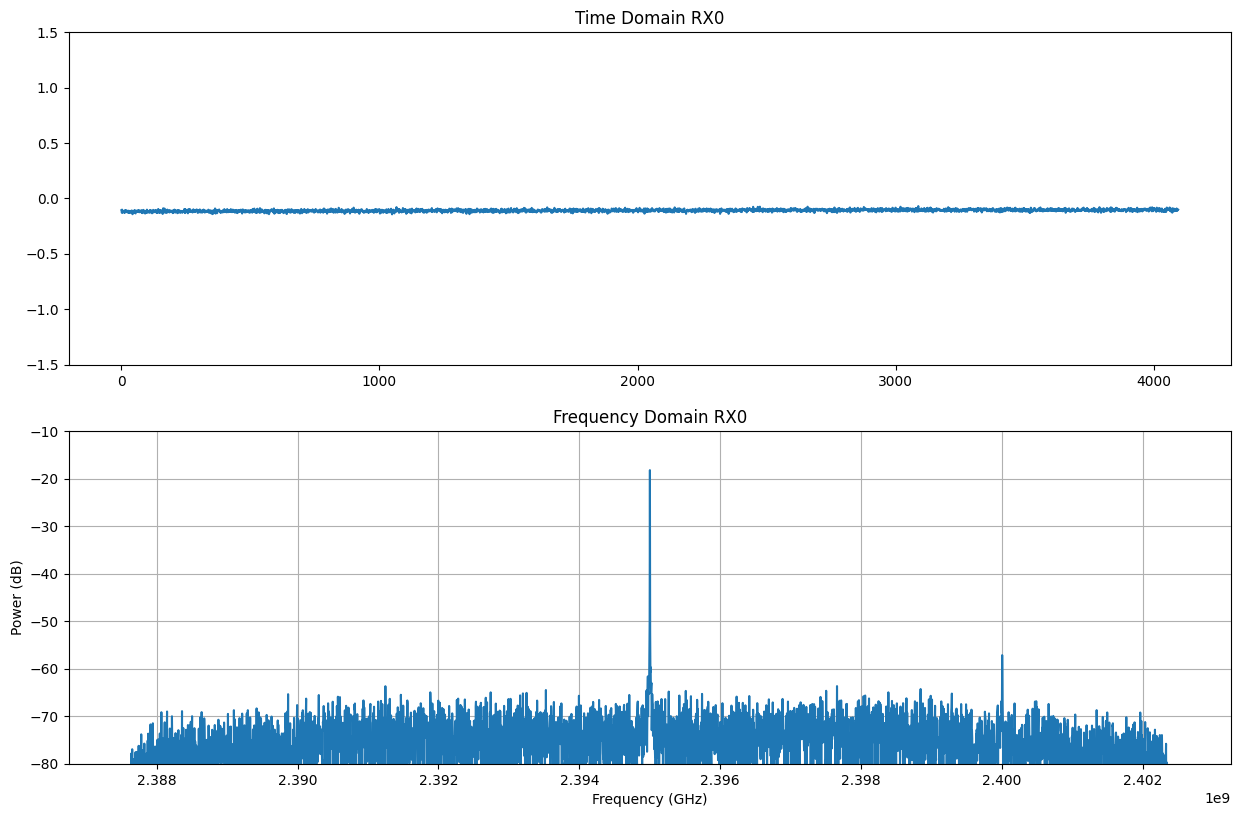

In [10]:

tx_rx = TX_RX()


tx_rx.receive()

f_carrier = np.linspace(-0.5 * tx_rx.SAMPLE_RATE, 0.5 * tx_rx.SAMPLE_RATE, len(tx_rx.data)) + tx_rx.OFFSET_CENTER_FREQ
data_fft = (20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(tx_rx.data))) / len(tx_rx.data)))

fig, ax = plt.subplots(2, 1, figsize=(15,9.5))

# timedomain, = ax[0].plot(np.linspace(0, 1, len(tx_rx.data)), np.real(tx_rx.data))
timedomain, = ax[0].plot(np.real(tx_rx.data))


ax[0].set_ylim(-1.5, 1.5)

ax[0].set_title("Time Domain RX0")

fftplot, = ax[1].plot(f_carrier, data_fft)

ax[1].set_ylabel("Power (dB)")

ax[1].set_xlabel("Frequency (GHz)")

ax[1].set_title("Frequency Domain RX0")

ax[1].set_ylim(-80, -10)

ax[1].grid()

tx_rx.close_dev()


In [11]:
buf = tx_rx.data

In [12]:
# N = 8192

# fs = tx_rx.SAMPLE_RATE

# fc = tx_rx.CENTER_FREQ

# ts = 1 / float(fs)

# t = np.arange(0, N * ts, ts)

# # radians = 2 * np.pi * t * fc

# # i = np.cos(radians) * 2 ** 14

# # q = np.sin(radians) * 2 ** 14
# # q = np.zeros(N)
# i = np.cos(2 * np.pi * t * fc)

# q = np.sin(2 * np.pi * t * fc)

# carrier_signal = i + 1j * q

# i = np.zeros(N)
# q = np.zeros(N)
# for k in range(N):
#     i[k] = np.round(2048.0 * np.cos(2.0 * k * np.pi / N))
#     q[k] = np.round(2048.0 * np.sin(2.0 * k * np.pi / N))
#     # i[k] = 2048
    
#     if(i[k] > 2047):
#         i[k] = 2047
#     if(i[k] < -2048):
#         i[k] = -2048
#     if(q[k] > 2047):
#         q[k] = 2047
#     if(q[k] < -2048):
#         q[k] = -2048          
# carrier_signal = i + 1j * q

Fs = (1e9 * 4)# sample rate
Ts = 1/Fs # sample period
N = 8192 # number of samples to simulate

t = Ts*np.arange(N)

carrier_signal = np.exp(1j*2*np.pi*(1e9)*t) # simulates sinusoid at 50 Hz

offset = 1


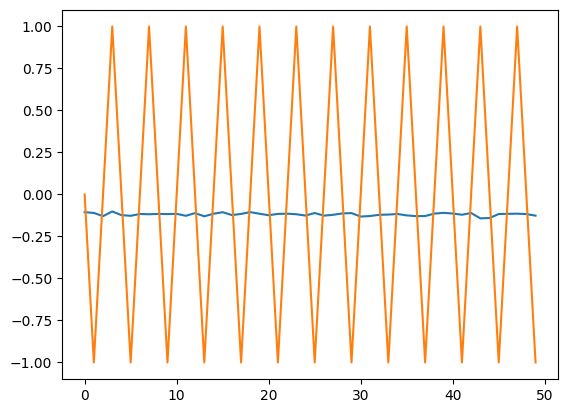

offset = 2


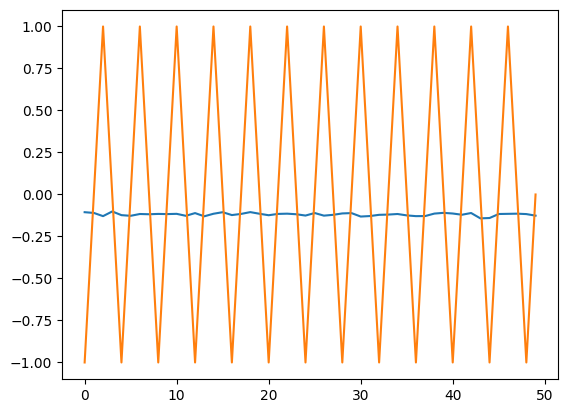

offset = 3


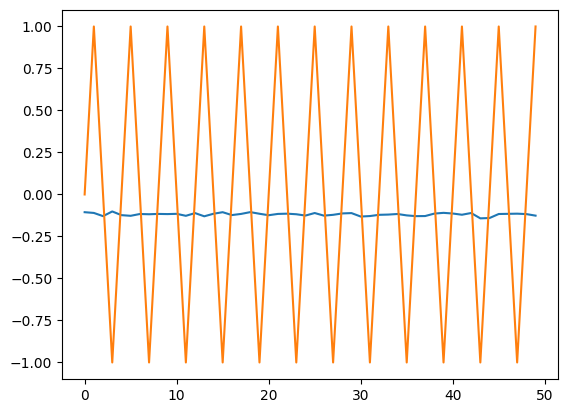

offset = 4


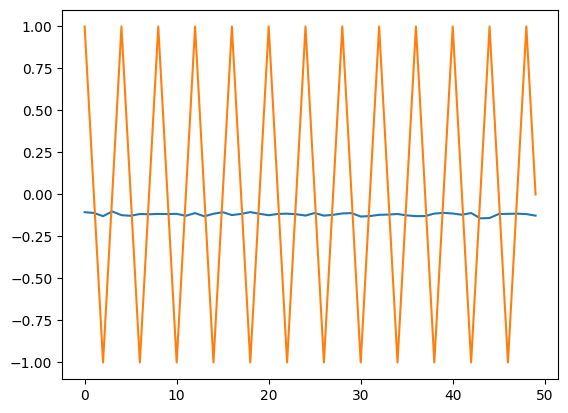

offset = 5


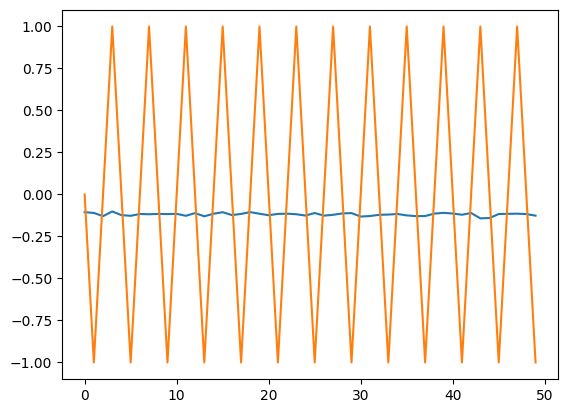

offset = 6


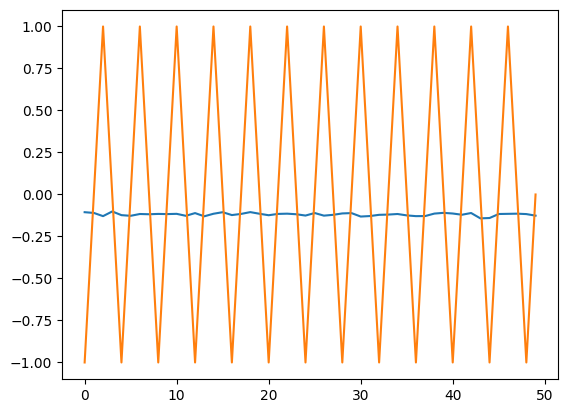

offset = 7


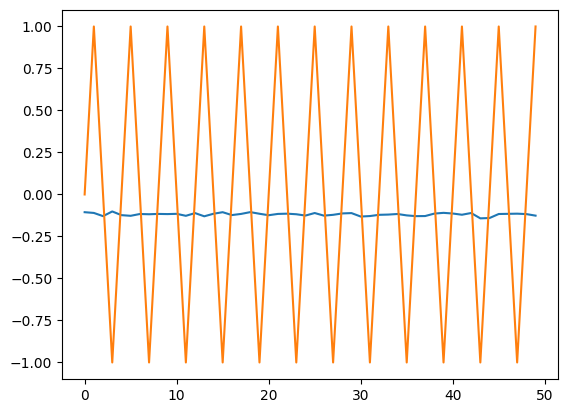

offset = 8


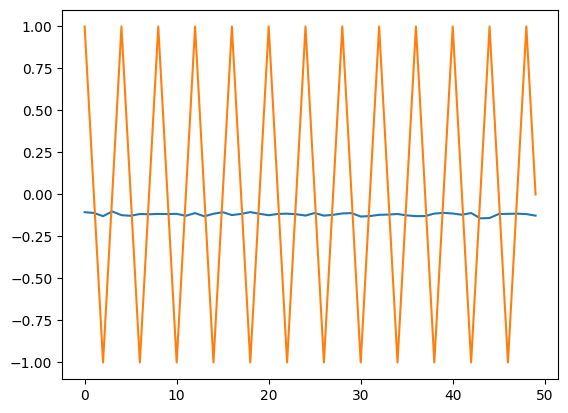

offset = 9


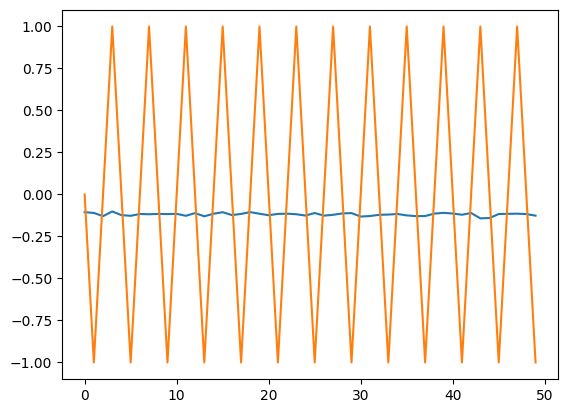

offset = 10


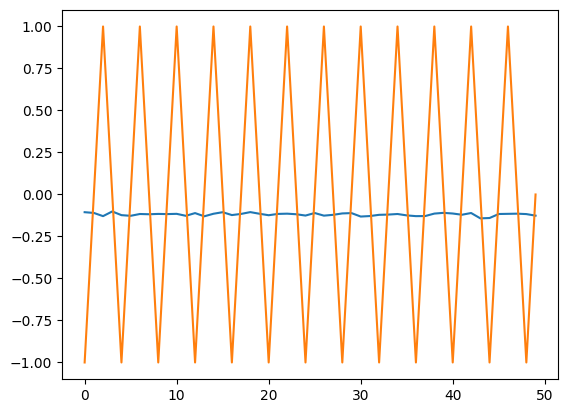

In [13]:
offset = 0
for i in range(10):
    offset += 1
    print("offset = {}".format(offset))
    plt.plot(buf[:50])
    plt.plot(carrier_signal[offset:50 + offset])
    plt.show()

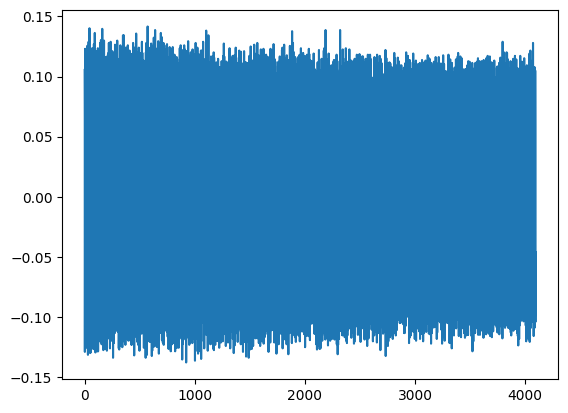

In [14]:
samples_per_symbol = 256

# phase_shift_rad = utils.phase_shift(carrier_signal[:len(buf)].real, buf.real)
# offset = carrier_phase_offset_index(phase_shift_rad)

# for i in range(50):

offset = 0
other_signal = buf * carrier_signal[offset:len(buf)+offset]

if(np.sum(other_signal[samples_per_symbol:samples_per_symbol*5]) < 0):
    other_signal *= -1

plt.plot(other_signal)
plt.show()

x_hat = sliding_window_view(other_signal[256:], window_shape=samples_per_symbol)

x = np.sum(x_hat, axis=1)

symbols = x[::samples_per_symbol]

bits = ~(symbols < 0)

realbits = bits.astype(int)

# i = 2
# while(realbits[i] == 1):
#     i+=1
# realbits = realbits[i+1:]


# print("{}\n{}".format(real_data, realbits))
